In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
     Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10

In [34]:
(train_data_original, _), (test_data_original, _) = cifar10.load_data()

In [35]:
train_data_original = train_data_original.astype('float32') / 255.
test_data_original = test_data_original.astype('float32') / 255.


Adding Noise

In [36]:
# Salt and Pepper Noise
def salt_pepper_noise(data):
    data1 = data.copy()
    count = 0
    for image in data1:
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      data1[count] = out
      count += 1
    return data1

In [37]:
train_data_noisy = salt_pepper_noise(train_data_original)
test_data_noisy = salt_pepper_noise(test_data_original)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


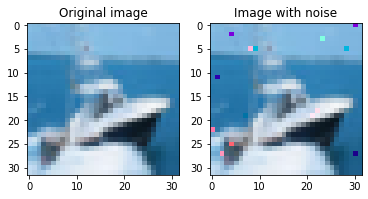

In [42]:
idx = 8
plt.subplot(1,2,1)
plt.imshow(train_data_original[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

In [43]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [47]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [46]:
def denoising_autoencoder():
      dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
      conv_block1 = conv_block(dae_inputs, 32, 3)
      conv_block2 = conv_block(conv_block1, 64, 3)
      conv_block3 = conv_block(conv_block2, 128, 3)
      conv_block4 = conv_block(conv_block3, 256, 3)
      conv_block5 = conv_block(conv_block4, 256, 3, 1)

      deconv_block1 = deconv_block(conv_block5, 256, 3)
      merge1 = Concatenate()([deconv_block1, conv_block3])
      
      deconv_block2 = deconv_block(merge1, 128, 3)
      merge2 = Concatenate()([deconv_block2, conv_block2])
      
      deconv_block3 = deconv_block(merge2, 64, 3)
      merge3 = Concatenate()([deconv_block3, conv_block1])
      
      deconv_block4 = deconv_block(merge3, 32, 3)

      final_deconv = Conv2DTranspose(filters=3,
                                      kernel_size=3,
                                      padding='same')(deconv_block4)
      dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
      
      return Model(dae_inputs, dae_outputs, name='dae')

In [51]:
dae = denoising_autoencoder()
dae.compile(loss='binary_crossentropy', optimizer='adam')
  
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
  
dae.fit(train_data_noisy,
      train_data_original,
      validation_data=(test_data_noisy, test_data_original),
      epochs=10,
      batch_size=128,
      callbacks=[checkpoint])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.5553
Epoch 00001: val_loss improved from inf to 0.57284, saving model to best_model.h5
391/391 [==============================] - 9s 24ms/step - loss: 0.5553 - val_loss: 0.5728
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.5501
Epoch 00002: val_loss improved from 0.57284 to 0.55215, saving model to best_model.h5
391/391 [==============================] - 9s 23ms/step - loss: 0.5501 - val_loss: 0.5522
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.5495
Epoch 00003: val_loss improved from 0.55215 to 0.55111, saving model to best_model.h5
391/391 [==============================] - 9s 24ms/step - loss: 0.5495 - val_loss: 0.5511
Epoch 4/10
390/391 [============================>.] - ETA: 0s - loss: 0.5491
Epoch 00004: val_loss improved from 0.55111 to 0.55086, saving model to best_model.h5
391/391 [==============================] - 9s 24ms/step - loss: 0.5491 - val_loss:

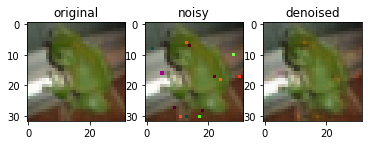

In [53]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 7
plt.subplot(1,3,1)
plt.imshow(test_data_original[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()